# March Machine Learning Mania 2017

In [1]:
import csv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

## Season 分析

### 读取数据

先读取RegularSeasonCompactResults、Teams两份数据，做最基本的分析。RegularSeasonCompactResults的数据是从1985年开始的。

In [2]:
# 读取RegularSeasonCompactResults
df_rscr = pd.read_csv('data/RegularSeasonCompactResults.csv')
df_rscr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [3]:
# 读取Teams
df_teams = pd.read_csv('data/Teams.csv')
df_teams.head()

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


### 主客场胜率

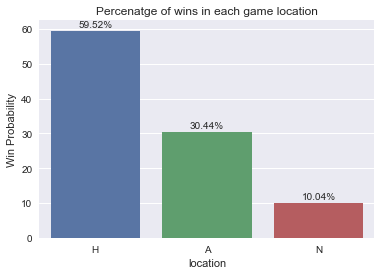

In [4]:
# 取Wolc列，并计数，并转为DataFrame，并求百分率
df_wloc = df_rscr['Wloc'].value_counts().reset_index().apply(lambda x: 100.0 * x / x.sum() if x.name != 'index' else x)

# 绘制bar plot
ax = sns.barplot(x='index', y='Wloc', data=df_wloc)
# 在图上写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1, '{:1.2f}%'.format(height), ha="center") 
# 标题、坐标的label
ax.set(xlabel='location', ylabel='Win Probability', title='Percenatge of wins in each game location')
plt.show()

### 加时情况

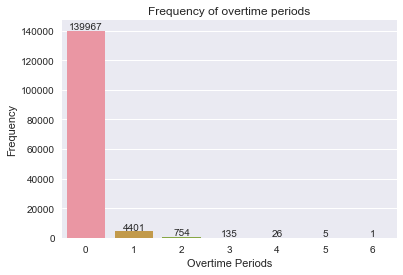

In [5]:
# 取 Numot 列，并计数
se_num_ot = df_rscr['Numot'].value_counts()

# 绘制bar plot
ax = sns.barplot(list(se_num_ot.axes[0]), se_num_ot.values)
# 写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1000, '{:1.0f}'.format(height), ha="center") 
# 标题
ax.set(xlabel='Overtime Periods', ylabel='Frequency', title='Frequency of overtime periods')
plt.show()

### Win percentage for all teams

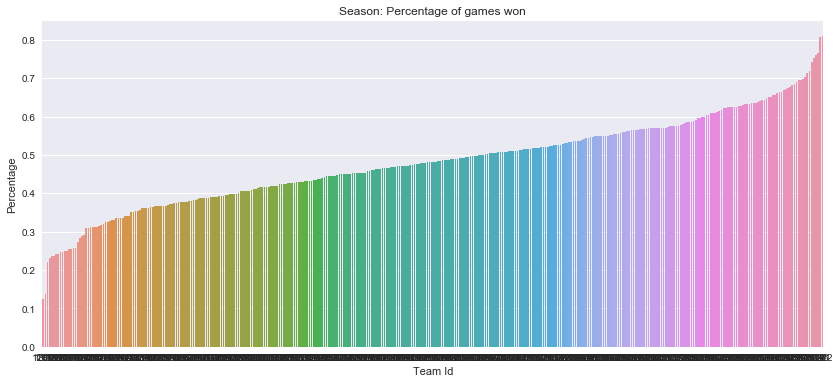

In [6]:
#分别统计每个球队的胜负场次，然后合并
df_win_per = pd.merge(
    df_rscr['Wteam'].value_counts().reset_index(),
    df_rscr['Lteam'].value_counts().reset_index(),
    on='index')
df_win_per.columns = ['Team_Id', 'Win', 'Loss']
# 计算胜率
df_win_per['Percentage'] = df_win_per['Win'] / (df_win_per['Win'] + df_win_per['Loss'])
# 球队名字
df_win_per = pd.merge(df_win_per, df_teams, on='Team_Id').sort_values('Percentage')

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.barplot(x='Team_Id', y='Percentage', data=df_win_per, order=list(df_win_per['Team_Id']))
ax.set(xlabel='Team Id', ylabel='Percentage', title='Season: Percentage of games won')
plt.show()

"What are the top 30 teams? "

In [7]:
# 胜率最好的30支球队
df_top_30 = df_win_per.tail(30)[::-1]

# 显示前15支 
df_top_30.head(15)

,Team_Id,Win,Loss,Percentage,Team_Name
1,1242,804,189,0.809668,Kansas
0,1181,819,194,0.808490,Duke
2,1246,765,234,0.765766,Kentucky
4,1112,746,235,0.760449,Arizona
3,1314,761,249,0.753465,North Carolina
5,1393,738,255,0.743202,Syracuse
13,1211,663,258,0.719870,Gonzaga
9,1462,681,273,0.713836,Xavier
7,1424,685,289,0.703285,UNLV
6,1272,692,300,0.697581,Memphis


"What are the worst 30 teams? "

In [8]:
# 胜率最差的30支球队
df_worst_30 = df_win_per.head(30)

# 显示前15支 
df_worst_30.head(15)

,Team_Id,Win,Loss,Percentage,Team_Name
362,1289,6,42,0.125000,Morris Brown
363,1327,3,19,0.136364,Okla City
361,1118,6,21,0.222222,Armstrong St
346,1146,62,205,0.232210,Cent Arkansas
359,1101,18,58,0.236842,Abilene Chr
311,1152,205,660,0.236994,Chicago St
340,1255,83,261,0.241279,Longwood
358,1445,26,81,0.242991,W Salem St
348,1188,51,156,0.246377,Edwardsville
308,1341,212,645,0.247375,Prairie View


### Average points scored for each team

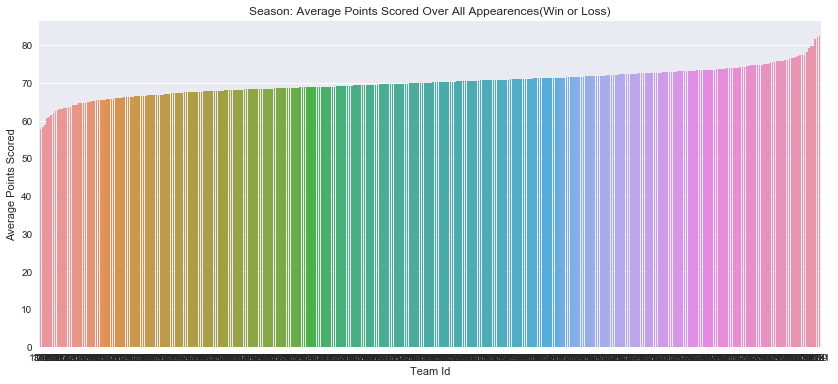

In [9]:
# 统计胜利、失败的情况下每个得分出现的次数
df_win_points = df_rscr.groupby(['Wteam', 'Wscore']).size().reset_index(name='Win').rename(columns={'Wteam':'Team_Id', 'Wscore': 'Score'})
df_loss_points = df_rscr.groupby(['Lteam', 'Lscore']).size().reset_index(name='Loss').rename(columns={'Lteam':'Team_Id', 'Lscore': 'Score'})
# 合并胜利、失败的数据
df_points = pd.merge(df_win_points, df_loss_points, on=['Team_Id', 'Score'], how='outer').fillna(0)

# 求平均得分
df_points['Total'] = df_points['Win'] + df_points['Loss']
df_points['Total_Score'] = df_points['Score'] * df_points['Total']
df_points = df_points.groupby('Team_Id').apply(lambda x: x['Total_Score'].sum() / x['Total'].sum()).reset_index(name='Score')

# 球队名字，排序
df_points = pd.merge(df_points, df_teams, on='Team_Id').sort_values('Score')

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.barplot(x='Team_Id', y='Score', data=df_points, order=list(df_points['Team_Id']))
ax.set(xlabel='Team Id', ylabel='Average Points Scored', title='Season: Average Points Scored Over All Appearences(Win or Loss)')
plt.show()

"What are the top 30 teams? "

In [10]:
df_points_top_30 = df_points[::-1].head(30)

df_points_top_30.head(15)

,Team_Id,Score,Team_Name
80,1181,82.393880,Duke
8,1109,82.242604,Alliant Intl
213,1314,81.620792,North Carolina
141,1242,79.873112,Kansas
227,1328,79.760331,Oklahoma
11,1112,79.305810,Arizona
15,1116,78.254082,Arkansas
145,1246,77.401401,Kentucky
323,1424,77.339836,UNLV
299,1400,77.270876,Texas


"What are the worst 30 teams? "

In [11]:
df_points_worst_30 = df_points.head(30)

df_points_worst_30.head(15)

,Team_Id,Score,Team_Name
265,1366,57.895833,Savannah St
188,1289,58.354167,Morris Brown
344,1445,58.738318,W Salem St
14,1115,60.630769,Ark Pine Bluff
241,1342,60.973077,Presbyterian
242,1343,61.542067,Princeton
26,1127,61.932127,Binghamton
345,1446,62.479167,W Texas A&M
61,1162,62.921781,Columbia
314,1415,62.978469,UC Riverside


### How does the number of points scored correlate to the game result?

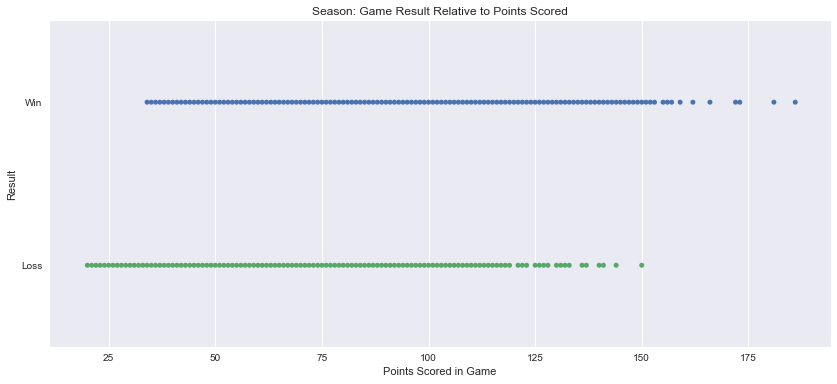

In [12]:
# 获取胜利得分分布，为了更快的处理，这里用unique函数代替value属性
df1=pd.DataFrame(df_rscr['Wscore'].unique(), columns=['Score']).assign(Result='Win')
# 获取失败得分分布
df2=pd.DataFrame(df_rscr['Lscore'].unique(), columns=['Score']).assign(Result='Loss')
# 得分与结果
df_points_result = pd.concat([df1, df2], ignore_index=True)

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.stripplot(x="Score", y="Result", data=df_points_result)
ax.set(xlabel='Points Scored in Game', ylabel='Result', title='Season: Game Result Relative to Points Scored')
plt.show()

### Win probability across features

看看各个特征与胜率的关系。需要读取RegularSeasonDetailedResults数据。RegularSeasonDetailedResults数据是从2003年开始的，所以跟上面的看起来会有些不一致。

In [13]:
# 读取RegularSeasonDetailedResults
df_rsdr = pd.read_csv('data/RegularSeasonDetailedResults.csv')
df_rsdr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


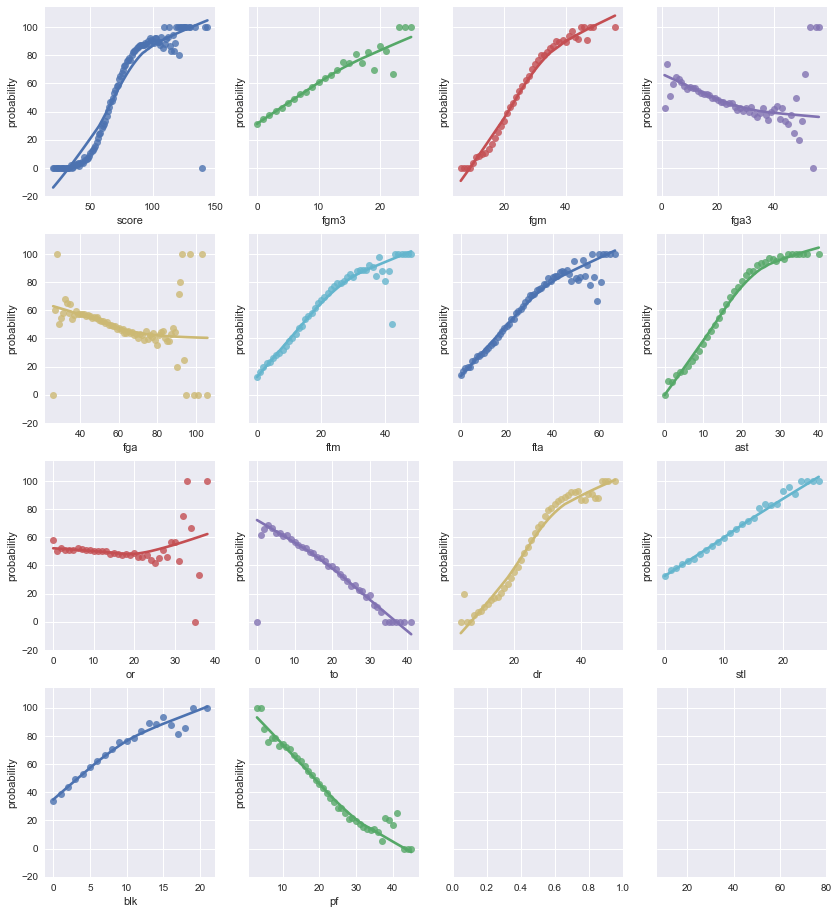

In [14]:
def cal_probability(_name):
    """ 计算特征与胜率的关系
    """
    df1 = df_rsdr['W%s' % _name].value_counts().reset_index().rename(columns={'index':_name, 'W%s' % _name:'win_num'})
    df2 = df_rsdr['L%s' % _name].value_counts().reset_index().rename(columns={'index':_name, 'L%s' % _name:'loss_num'})

    df = pd.merge(df1, df2, how='outer', on=_name).fillna(0)
    df['probability'] = 100.0 * df['win_num'] / (df['win_num'] + df['loss_num'])
    
    return df

# 要看的特征
names = ['score', 'fgm3', 'fgm', 'fga3', 'fga', 'ftm', 'fta', 'ast', 'or', 'to', 'dr', 'stl', 'blk', 'pf']

# 计算特征与胜率的关系，并绘图
fig, ax = plt.subplots(4, 4, figsize=(14, 16), sharey=True)
i = 0
for n in names:
    df = cal_probability(n)
    sns.regplot(x=n, y="probability", data=df, lowess=True, ax=ax[int(i / 4)][i % 4])
    i += 1
plt.show()

### Win probability using efficiency metrics

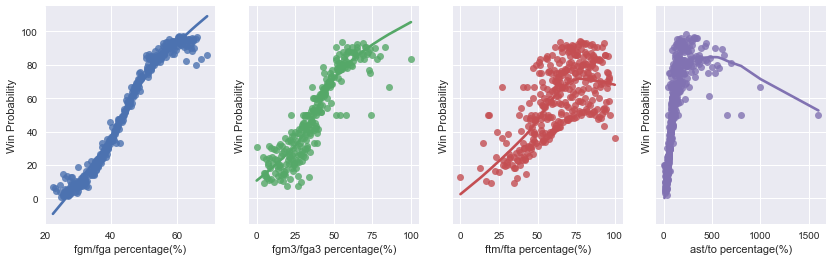

In [15]:
def cal_probability2(_name1, _name2):
    df_rsdr2 = df_rsdr[df_rsdr['W%s' % _name2] > 0]
    df1 = pd.DataFrame((100 * df_rsdr2['W%s' % _name1] / df_rsdr2['W%s' % _name2]).round(1).value_counts(), columns=['Win']).reset_index()
    
    df_rsdr2 = df_rsdr[df_rsdr['L%s' % _name2] > 0]
    df2 = pd.DataFrame((100 * df_rsdr2['L%s' % _name1] / df_rsdr2['L%s' % _name2]).round(1).value_counts(), columns=['Loss']).reset_index()
    
    df = pd.merge(df1, df2, how='inner', on='index')
    df['Probability'] = 100 * df['Win'] / (df['Win'] + df['Loss'])
    df.sort_values('index')
    
    return df


# 要看的特征
names = [['fgm', 'fga'], ['fgm3', 'fga3'], ['ftm', 'fta'], ['ast', 'to']] #

# 计算特征与胜率的关系，并绘图
fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
i = 0
for n in names:
    df = cal_probability2(n[0], n[1])
    sns.regplot(x='index', y="Probability", data=df, lowess=True, ax=ax[i])
    ax[i].set(xlabel=('%s/%s percentage(%%)' % (n[0], n[1])), ylabel='Win Probability')
    i += 1
plt.show()

## Tournament分析

### 读取数据

In [16]:
# 读取TourneyDetailedResults
df_tdr = pd.read_csv('data/TourneyDetailedResults.csv')
df_tdr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


### Frequency of overtime periods

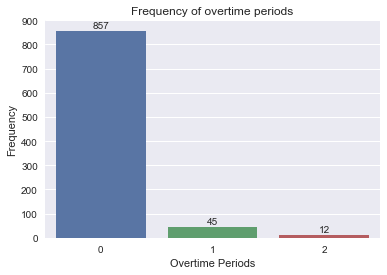

In [17]:
# 取 Numot 列，并计数
se_num_ot = df_tdr['Numot'].value_counts()

# 绘制bar plot
ax = sns.barplot(list(se_num_ot.axes[0]), se_num_ot.values)
# 写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 
# 标题
ax.set(xlabel='Overtime Periods', ylabel='Frequency', title='Frequency of overtime periods')
plt.show()

### Win percentage for all teams

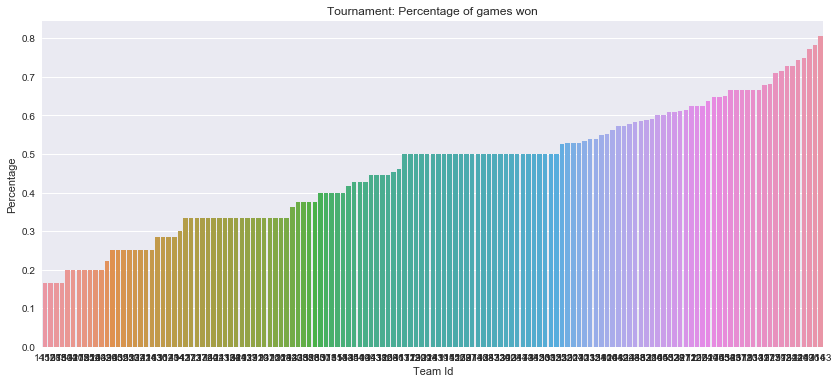

In [18]:
#分别统计每个球队的胜负场次，然后合并
df_win_per = pd.merge(
    df_tdr['Wteam'].value_counts().reset_index(),
    df_tdr['Lteam'].value_counts().reset_index(),
    on='index')
df_win_per.columns = ['Team_Id', 'Win', 'Loss']
# 计算胜率
df_win_per['Percentage'] = df_win_per['Win'] / (df_win_per['Win'] + df_win_per['Loss'])
# 球队名字
df_win_per = pd.merge(df_win_per, df_teams, on='Team_Id').sort_values('Percentage')

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.barplot(x='Team_Id', y='Percentage', data=df_win_per, order=list(df_win_per['Team_Id']))
ax.set(xlabel='Team Id', ylabel='Percentage', title='Tournament: Percentage of games won')
plt.show()

What are the top 30 teams?

In [19]:
# 胜率最好的30支球队
df_top_30 = df_win_per.tail(30)[::-1]

# 显示前15支 
df_top_30.head(15)

,Team_Id,Win,Loss,Percentage,Team_Name
5,1163,29,7,0.805556,Connecticut
0,1314,36,10,0.782609,North Carolina
6,1196,27,8,0.771429,Florida
74,1247,3,1,0.750000,La Salle
2,1246,32,11,0.744186,Kentucky
1,1242,35,13,0.729167,Kansas
3,1181,32,12,0.727273,Duke
9,1393,25,10,0.714286,Syracuse
7,1257,27,11,0.710526,Louisville
4,1277,30,14,0.681818,Michigan St


What are the worst 30 teams?

In [20]:
# 胜率最差的30支球队
df_worst_30 = df_win_per.head(30)

# 显示前15支 
df_worst_30.head(15)

,Team_Id,Win,Loss,Percentage,Team_Name
108,1457,1,5,0.166667,Winthrop
107,1107,1,5,0.166667,Albany NY
121,1285,1,5,0.166667,Montana
101,1160,1,5,0.166667,Colorado
115,1344,1,4,0.200000,Providence
137,1330,1,4,0.200000,Old Dominion
118,1278,1,4,0.200000,Minnesota
103,1155,1,4,0.200000,Clemson
126,1214,1,4,0.200000,Hampton
116,1264,1,4,0.200000,Manhattan


### Average points scored for each team

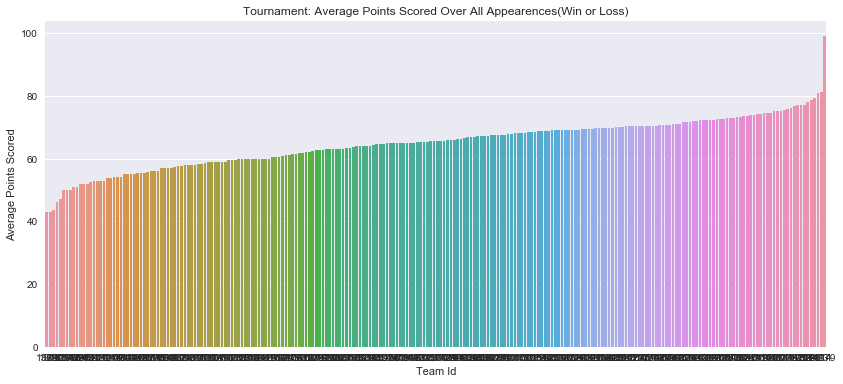

In [21]:
# 统计胜利、失败的情况下每个得分出现的次数
df_win_points = df_tdr.groupby(['Wteam', 'Wscore']).size().reset_index(name='Win').rename(columns={'Wteam':'Team_Id', 'Wscore': 'Score'})
df_loss_points = df_tdr.groupby(['Lteam', 'Lscore']).size().reset_index(name='Loss').rename(columns={'Lteam':'Team_Id', 'Lscore': 'Score'})
# 合并胜利、失败的数据
df_points = pd.merge(df_win_points, df_loss_points, on=['Team_Id', 'Score'], how='outer').fillna(0)

# 求平均得分
df_points['Total'] = df_points['Win'] + df_points['Loss']
df_points['Total_Score'] = df_points['Score'] * df_points['Total']
df_points = df_points.groupby('Team_Id').apply(lambda x: x['Total_Score'].sum() / x['Total'].sum()).reset_index(name='Score')

# 球队名字，排序
df_points = pd.merge(df_points, df_teams, on='Team_Id').sort_values('Score')

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.barplot(x='Team_Id', y='Score', data=df_points, order=list(df_points['Team_Id']))
ax.set(xlabel='Team Id', ylabel='Average Points Scored', title='Tournament: Average Points Scored Over All Appearences(Win or Loss)')
plt.show()

What are the top 30 teams?

In [22]:
df_points_top_30 = df_points[::-1].head(30)

df_points_top_30.head(15)

,Team_Id,Score,Team_Name
50,1179,99.000000,Drake
130,1314,81.347826,North Carolina
199,1423,81.000000,UNC Wilmington
218,1449,79.428571,Washington
110,1281,78.727273,Missouri
46,1174,78.000000,Delaware
72,1222,77.000000,Houston
92,1253,77.000000,Long Beach St
131,1316,77.000000,North Florida
217,1448,76.600000,Wake Forest


What are the worst 30 teams?

In [23]:
df_points_worst_30 = df_points.head(30)

df_points_worst_30.head(15)

,Team_Id,Score,Team_Name
179,1389,43.0,St Peter's
170,1376,43.0,South Carolina
115,1290,43.5,MS Valley St
47,1175,46.0,Delaware St
197,1420,47.0,UMBC
119,1294,50.0,N Colorado
49,1178,50.0,Detroit
164,1368,50.0,SE Louisiana
213,1439,51.0,Virginia Tech
163,1364,51.0,Santa Barbara


### How does the number of points scored correlate to the game result?

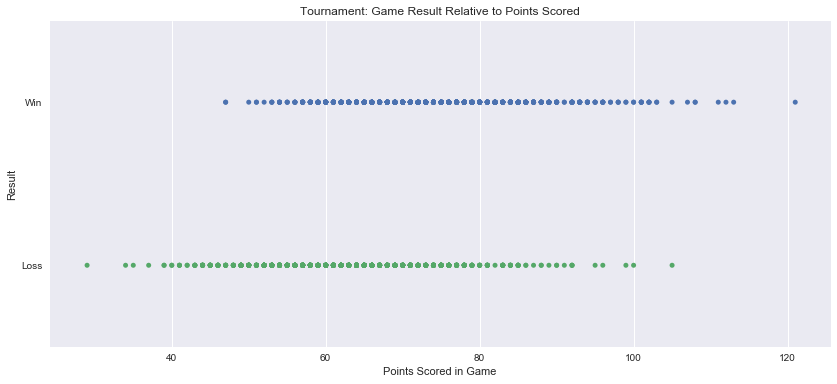

In [24]:
# 获取胜利得分分布
df1=pd.DataFrame(df_tdr['Wscore'].values, columns=['Score']).assign(Result='Win')
# 获取失败得分分布
df2=pd.DataFrame(df_tdr['Lscore'].values, columns=['Score']).assign(Result='Loss')
# 得分与结果
df_points_result = pd.concat([df1, df2], ignore_index=True)

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.stripplot(x="Score", y="Result", data=df_points_result)
ax.set(xlabel='Points Scored in Game', ylabel='Result', title='Tournament: Game Result Relative to Points Scored')
plt.show()

### Win probability across features

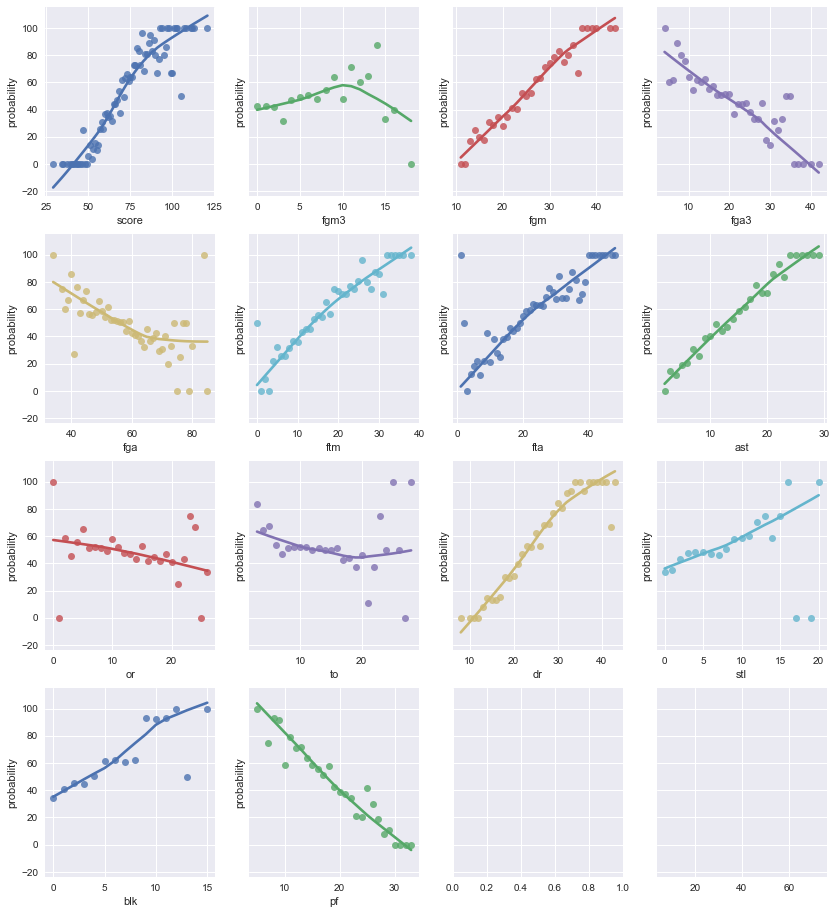

In [25]:
def cal_probability(_name):
    """ 计算特征与胜率的关系
    """
    df1 = df_tdr['W%s' % _name].value_counts().reset_index().rename(columns={'index':_name, 'W%s' % _name:'win_num'})
    df2 = df_tdr['L%s' % _name].value_counts().reset_index().rename(columns={'index':_name, 'L%s' % _name:'loss_num'})

    df = pd.merge(df1, df2, how='outer', on=_name).fillna(0)
    df['probability'] = 100.0 * df['win_num'] / (df['win_num'] + df['loss_num'])
    
    return df

# 要看的特征
names = ['score', 'fgm3', 'fgm', 'fga3', 'fga', 'ftm', 'fta', 'ast', 'or', 'to', 'dr', 'stl', 'blk', 'pf']

# 计算特征与胜率的关系，并绘图
fig, ax = plt.subplots(4, 4, figsize=(14, 16), sharey=True)
i = 0
for n in names:
    df = cal_probability(n)
    sns.regplot(x=n, y="probability", data=df, lowess=True, ax=ax[int(i / 4)][i % 4])
    i += 1
plt.show()

### Win probability using efficiency metrics

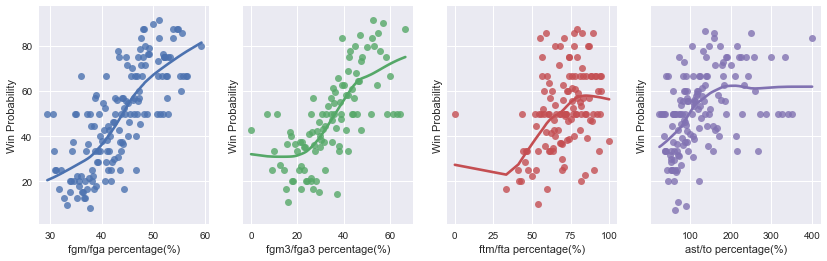

In [26]:
def cal_probability2(_name1, _name2):
    df_tdr2 = df_tdr[df_tdr['W%s' % _name2] > 0]
    df1 = pd.DataFrame((100 * df_tdr2['W%s' % _name1] / df_tdr2['W%s' % _name2]).round(1).value_counts(), columns=['Win']).reset_index()
    
    df_tdr2 = df_tdr[df_tdr['L%s' % _name2] > 0]
    df2 = pd.DataFrame((100 * df_tdr2['L%s' % _name1] / df_tdr2['L%s' % _name2]).round(1).value_counts(), columns=['Loss']).reset_index()
    
    df = pd.merge(df1, df2, how='inner', on='index')
    df['Probability'] = 100 * df['Win'] / (df['Win'] + df['Loss'])
    df.sort_values('index')
    
    return df


# 要看的特征
names = [['fgm', 'fga'], ['fgm3', 'fga3'], ['ftm', 'fta'], ['ast', 'to']] #

# 计算特征与胜率的关系，并绘图
fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
i = 0
for n in names:
    df = cal_probability2(n[0], n[1])
    sns.regplot(x='index', y="Probability", data=df, lowess=True, ax=ax[i])
    ax[i].set(xlabel=('%s/%s percentage(%%)' % (n[0], n[1])), ylabel='Win Probability')
    i += 1
plt.show()